In [1]:
import numpy as np
import torch,  os
import pandas as pd
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch.nn.functional as F
import cv2

In [22]:
# load data

train_df = pd.read_csv(r'./train.csv')
test_df = pd.read_csv(r'./test.csv')
train_picture_path=  r'./train'
test_picture_path = r'./test_images/'
zoom=32
IMG_SIZE = zoom
NUM_CLASSES = 10
GRAYSCALE = False

In [5]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [6]:
def load_images(x,zoom , dir_path):
    return cv2.resize(cv2.imread(os.path.join(dir_path , x)),(zoom,zoom))

In [7]:
# Create a Dataset to hold the input data and make it available to dataloader
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i]
        data = np.array(data).astype(np.uint8).reshape(IMG_SIZE, IMG_SIZE, 3)
        
        if self.transforms:
            data = self.transforms(data)
            
            # Also return label if we have it
            if self.y is not None:
                return (data, self.y[i])
            else:
                return data    

In [8]:
train_df.head()

,ID,Label
0,train_00000.png,0
1,train_00001.png,1
2,train_00002.png,1
3,train_00003.png,5
4,train_00004.png,5


In [9]:
train_df['Data'] = train_df['ID'].apply(lambda x : load_images(x,zoom , train_picture_path))
test_df['Data'] = test_df['ID'].apply(lambda x : load_images(x , zoom, test_picture_path))

In [10]:
all_train_labels=train_df['Label']
all_train_images = train_df['Data']

test_images = test_df['Data']

# Split training data so we have a small validation set and training set
train_images, val_images, train_labels, val_labels = train_test_split(all_train_images, all_train_labels, test_size=0.2)

# Reindex so we can refer to first element using index 0
train_images.reset_index(drop=True, inplace=True)
val_images.reset_index(drop=True, inplace=True)
train_labels.reset_index(drop=True, inplace=True)
val_labels.reset_index(drop=True, inplace=True)

In [11]:
# Training Image transformations
train_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)
# Validation Image transformations
val_trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
]
)


In [12]:
# Create data loaders
batch_size = 64

train_dataset = MyDataset(train_images, train_labels, train_trans)
val_dataset = MyDataset(val_images, val_labels, val_trans)
test_dataset = MyDataset(test_images, None, val_trans)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


In [26]:
class LeNet5(nn.Module):
    # calculate same padding:
    # (w - k + 2*p)/s + 1 = o
    # => p = (s(o-1) - w + k)/2
    def __init__(self , num_classes , grayscale= False):
        super(LeNet5,self).__init__()
        
        self.num_classes = num_classes
        self.grayscale = grayscale
        
        if grayscale:
            in_channels = 1
        else :
            in_channels = 3
            
        self.feature = nn.Sequential(
            nn.Conv2d(
            in_channels=in_channels,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=2,
            ),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16,32,5,1,2),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(32*8*8,120),
            nn.Linear(120,64),
            nn.Linear(64,self.num_classes))
                    
    def forward(self,x):
        x = self.feature(x)
        x = torch.flatten(x,1)
        logits = self.classifier(x)

        
        return logits

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = LeNet5(NUM_CLASSES , GRAYSCALE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [31]:
LeNet5(NUM_CLASSES , GRAYSCALE)

LeNet5(
  (feature): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=64, bias=True)
    (2): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [29]:
# Train the model

epochs = 30

train_losses, val_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in train_loader:
        # Clear last image's results
        optimizer.zero_grad()
        log_ps = model(images)
        loss = F.cross_entropy(log_ps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    else:
        val_loss = 0
        accuracy = 0
        with torch.no_grad():
            for images, labels in val_loader:
                log_ps = model(images)
                val_loss +=  F.cross_entropy(log_ps, labels)
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        train_losses.append(running_loss/len(train_loader))
        val_losses.append(val_loss/len(val_loader))
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
             "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
             "Validation Loss: {:.3f}.. ".format(val_loss/len(val_loader)),
             "Accuracy: {:.3f}".format(accuracy/len(val_loader)))
        

Epoch: 1/30..  Training Loss: 2.139..  Validation Loss: 2.074..  Accuracy: 0.245
Epoch: 2/30..  Training Loss: 1.966..  Validation Loss: 1.926..  Accuracy: 0.246
Epoch: 3/30..  Training Loss: 1.829..  Validation Loss: 1.834..  Accuracy: 0.245
Epoch: 4/30..  Training Loss: 1.756..  Validation Loss: 1.774..  Accuracy: 0.245
Epoch: 5/30..  Training Loss: 1.710..  Validation Loss: 1.730..  Accuracy: 0.244
Epoch: 6/30..  Training Loss: 1.683..  Validation Loss: 1.704..  Accuracy: 0.246
Epoch: 7/30..  Training Loss: 1.668..  Validation Loss: 1.694..  Accuracy: 0.244
Epoch: 8/30..  Training Loss: 1.662..  Validation Loss: 1.682..  Accuracy: 0.245
Epoch: 9/30..  Training Loss: 1.653..  Validation Loss: 1.678..  Accuracy: 0.245
Epoch: 10/30..  Training Loss: 1.647..  Validation Loss: 1.676..  Accuracy: 0.244
Epoch: 11/30..  Training Loss: 1.647..  Validation Loss: 1.670..  Accuracy: 0.245
Epoch: 12/30..  Training Loss: 1.642..  Validation Loss: 1.667..  Accuracy: 0.244
Epoch: 13/30..  Training 

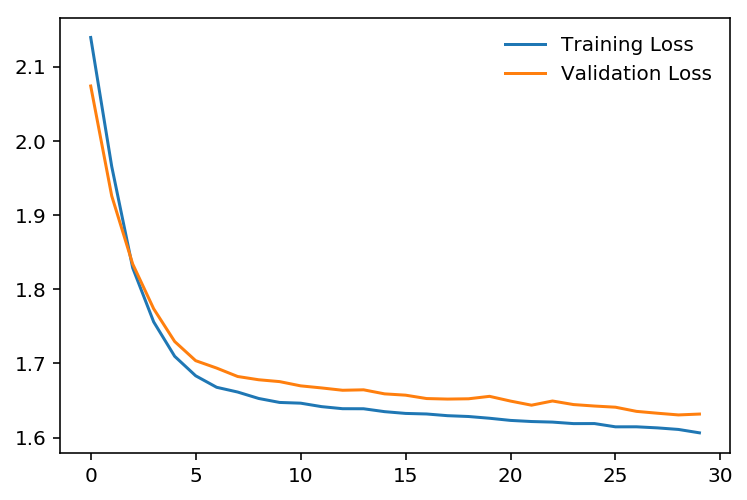

In [30]:
# Plot the losses
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend(frameon=False);